# Setup & Helper Functions

In [185]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import skimage
from PIL import Image

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [186]:
# parse input image into function (training data)
def load_image_data(img_path, resolution=200, square_pad=False):
    raw_img = Image.open(img_path).convert('RGB')

    raw_width, raw_height = raw_img.size
    aspect = raw_width / raw_height
    raw_img = raw_img.resize((int(resolution * aspect), resolution));

    img = np.array(raw_img) / 255.

    width_unpadded = img.shape[1]
    
    # if desired, add white padding on left and right to make image square
    if square_pad:
        diff = (resolution - img.shape[1]) / 2
        if diff > 0:
            img = np.concatenate([
                np.ones([img.shape[0], int(np.floor(diff)), 3]),
                img,
                np.ones([img.shape[0], int(np.ceil(diff)), 3]),
            ], axis=1)
        else: # too wide, truncate
            img = img[:, int(np.floor(-diff)):int(np.floor(-diff)) + resolution, :]
            print(img.shape)
        aspect=1

    width, height = img.shape[0], img.shape[1] # may be flipped?
    n = width * height
    X = []
    Y = []
    for i in range(width):
        for j in range(height):
            X.append([i / width, j / height])
            Y.append(img[i][j])
    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)    
    return X, Y, img, aspect, width_unpadded

In [187]:
# custom dataset class to support multiple output labels (r,g,b)
class ImageAsDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Parse Image Inputs

# 1) Neural Image Painting
Regression for f(x, y) -> (r, g, b)

x, y in [0, 1], (r,g,b) also in [0,1]

image shape (400, 739, 3)
max value 0.9019607843137255
training data shape (295600, 2)
labels shape (295600, 3)
aspect ratio 1.8497109826589595


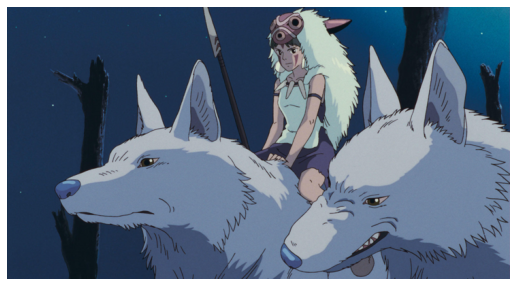

In [190]:
X, Y, original_img, aspect, _ = load_image_data('mononoke014.jpg', resolution=400, square_pad=False)

plt.figure(figsize=(10, 5))
plt.imshow(original_img)
plt.axis('off')
print('image shape', original_img.shape)
print('max value', np.max(original_img))
print('training data shape', X.shape)
print('labels shape', Y.shape)
print('aspect ratio', aspect)

dataset = ImageAsDataset(X, Y)

In [191]:
# draw image
def draw_image(model, height=200, aspect=1):
    width = int(height * aspect)
    img = np.zeros([height, width, 3])
    model.eval()
    with torch.no_grad():
        for i in range(width):
            input = np.ones([height, 2]) * i / width
            input[:,0] = np.linspace(0, 1, num=height);
            img[:,i] = model(torch.Tensor(input).to(device)).detach().cpu().numpy()

    return img

In [193]:
# define model and optimization parameters

hidden_size = 20

model = nn.Sequential(
    nn.Linear(2, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, 3),
    nn.Sigmoid(),
).to(device)

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4);
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

print(model)

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): Tanh()
  (8): Linear(in_features=20, out_features=20, bias=True)
  (9): Tanh()
  (10): Linear(in_features=20, out_features=20, bias=True)
  (11): Tanh()
  (12): Linear(in_features=20, out_features=20, bias=True)
  (13): Tanh()
  (14): Linear(in_features=20, out_features=20, bias=True)
  (15): Tanh()
  (16): Linear(in_features=20, out_features=3, bias=True)
  (17): Sigmoid()
)


In [ ]:
# training loop
from IPython.display import clear_output

n_epochs = 10000
prev_loss = 0
model.train()
for epoch in range(n_epochs):

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'epoch {epoch}: loss={running_loss}, diff={running_loss - prev_loss}')
    prev_loss = running_loss
    plt.figure(1, figsize=(10, 5))
    plt.imshow(draw_image(model, aspect=aspect))
    plt.show()
    clear_output(wait=True)
print('Finished Training')

(-0.5, 1848.5, 999.5, -0.5)

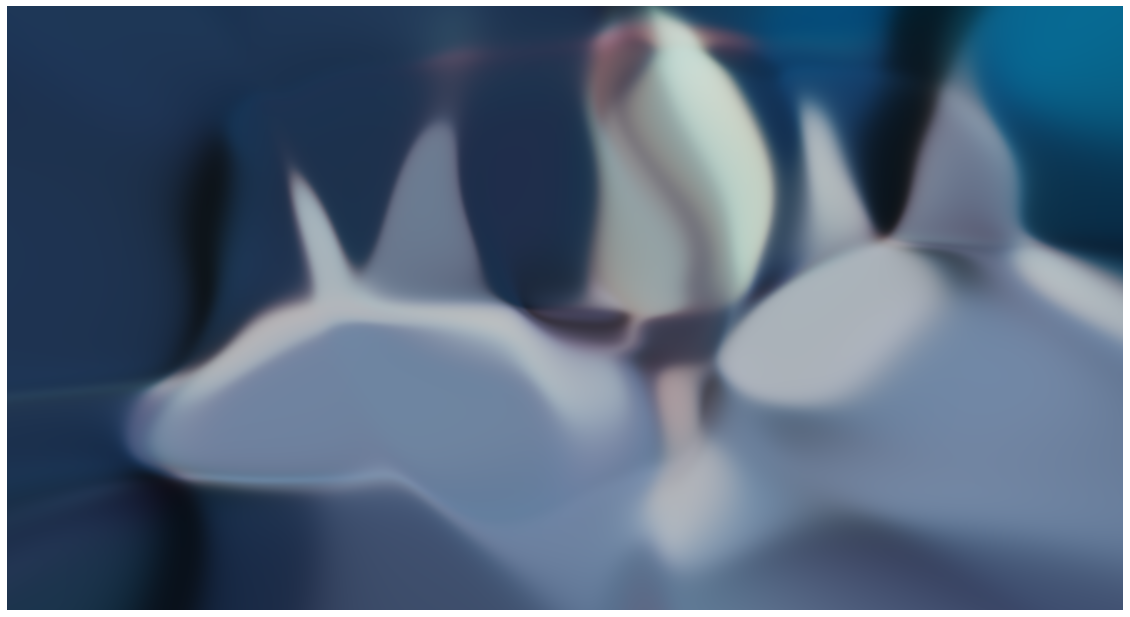

In [195]:
# show result

plt.figure(figsize=(20,20))
plt.imshow(draw_image(model, 1000, aspect=aspect))
plt.axis('off')

# 2) Conditional Letter Generation


## a) Load images and train model

In [196]:
# load letter image files for training

letters = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ') + ['comma', 'period', 'quoteright']
print(letters)
filenames = [f'drive/MyDrive/ArtML Projects/Project 2/fonts/dm_serif/{l}.png' for l in letters]
n_chars = len(letters)
X_list = []
Y_list = []
img_list = []
width_list = []

for i, letter_file in enumerate(filenames):
    X, Y, img, aspect, width_unpadded = load_image_data(letter_file, square_pad=True)
    onehot = np.zeros([len(X), n_chars])
    onehot[:, i] = 1
    X_conditional = np.concatenate((X, onehot), axis=1, dtype=np.float32)
    X_list.append(X_conditional)
    Y_list.append(Y)
    img_list.append(img)
    width_list.append(width_unpadded)

X_all = np.concatenate(X_list)
Y_all = np.concatenate(Y_list)
print('training shape', X_all.shape)
print('labels shape', Y_all.shape)

dataset = ImageAsDataset(X_all, Y_all)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'comma', 'period', 'quoteright']
training shape (1160000, 31)
labels shape (1160000, 3)


In [113]:
# function to draw image using the conditional network

def draw_image_conditional(model, index=0, height=200, aspect=1, custom_vector=None):
    width = int(height * aspect)
    img = np.zeros([height, width, 3])
    model.eval()
    with torch.no_grad():
        for i in range(width):
            input = np.zeros([height, 2 + n_chars])
            input[:,1] = i / width
            input[:,0] = np.linspace(0, 1, num=height);
            if (custom_vector is not None):
                custom_vector = np.array(custom_vector, dtype=np.float32)
                custom_vector /= np.linalg.norm(custom_vector)
                input[:,2:] = custom_vector
            else:
                input[:, 2 + index] = 1
            img[:,i] = model(torch.Tensor(input).to(device)).detach().cpu().numpy()

    return img

In [197]:
# conditional network, takes in both (x,y) position and a one-hot vector encoding the letters

hidden_size = 20

model = nn.Sequential(
    nn.Linear(2 + n_chars, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, 3),
    nn.Sigmoid(),
).to(device)

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4);
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

print(model)

Sequential(
  (0): Linear(in_features=31, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): Tanh()
  (8): Linear(in_features=20, out_features=20, bias=True)
  (9): Tanh()
  (10): Linear(in_features=20, out_features=20, bias=True)
  (11): Tanh()
  (12): Linear(in_features=20, out_features=20, bias=True)
  (13): Tanh()
  (14): Linear(in_features=20, out_features=20, bias=True)
  (15): Tanh()
  (16): Linear(in_features=20, out_features=3, bias=True)
  (17): Sigmoid()
)


In [ ]:
# training loop

from IPython.display import clear_output

n_epochs = 10000
noise = 0
prev_loss = 0
model.train()
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # test adding some noise to OHE vector for robustness
        # inputs[:, 2:] += torch.randn_like(inputs[:, 2:]) * noise
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'epoch {epoch}: loss={running_loss}, diff={running_loss - prev_loss}')
    prev_loss = running_loss
    for i in range(n_chars):
        drawn_image = draw_image_conditional(model, i, height=50)
        plt.figure(1, figsize=(30, 5))
        plt.subplot(1, n_chars, i+1)
        plt.axis('off')
        plt.imshow(drawn_image)
    plt.show()
    clear_output(wait=True)

print('Finished Training')

In [116]:
# save model
torch.save(model.state_dict(), 'drive/MyDrive/ArtML Projects/Project 2/models/model.pth')

## b) Test model with various tasks

In [198]:
# load model
model.load_state_dict(torch.load('drive/MyDrive/ArtML Projects/Project 2/models/times_40k.pth'))

<All keys matched successfully>

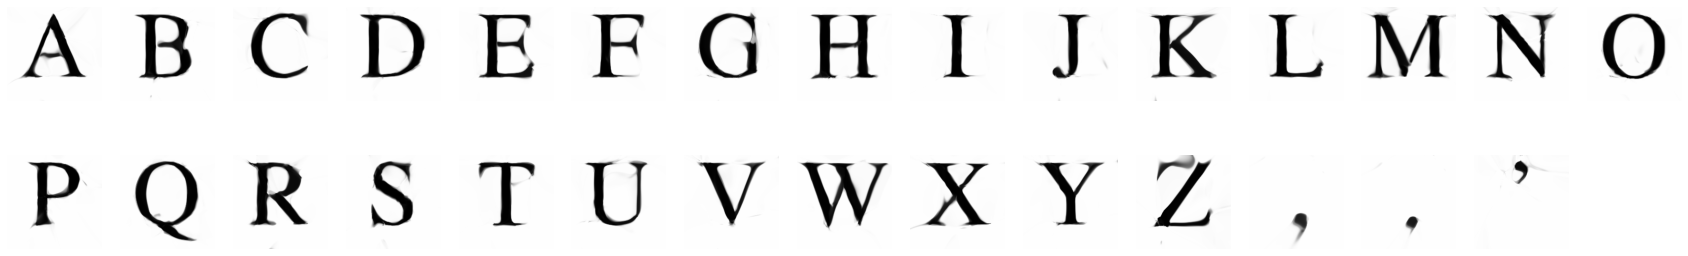

In [201]:
# draw alphabet

noise = 0
plt.figure(figsize=(30, 5))
for i in range(n_chars):
    vector=None
    if noise:
        vector = np.random.randn(n_chars) * noise
        # vector = np.random.uniform(-1, 1, size=n_chars) * noise # test uniform noise
        vector[i] += 1
    drawn_img = draw_image_conditional(model, i, height=200, custom_vector=vector)
    plt.subplot(2, int(np.ceil(n_chars/2.)), i+1)
    plt.axis('off')
    plt.imshow(drawn_img)

[-0.22650105 -0.50217913  0.97829978 -0.38549322  1.49713653  1.16947546
  0.07148338  0.663435    1.45532074  0.49489956  0.89701596  1.03967907
  0.24934295 -2.70456123  0.4540603  -0.6215142   0.08354033  0.81749233
 -0.81843401 -0.2152776  -0.65931649  0.25674705 -1.13022048  1.09570419
  0.14773823  0.11813005  0.74566711 -0.14226371  0.26689867]


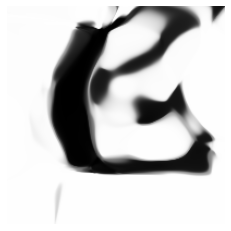

In [203]:
# randomly sample from latent space
vector = np.random.randn(n_chars) # gaussian noise
# vector = np.random.uniform(-1, 1, size=n_chars) # uniform noise 

print(vector)
drawn_img = draw_image_conditional(model, custom_vector=vector)
plt.axis('off')
plt.imshow(drawn_img)

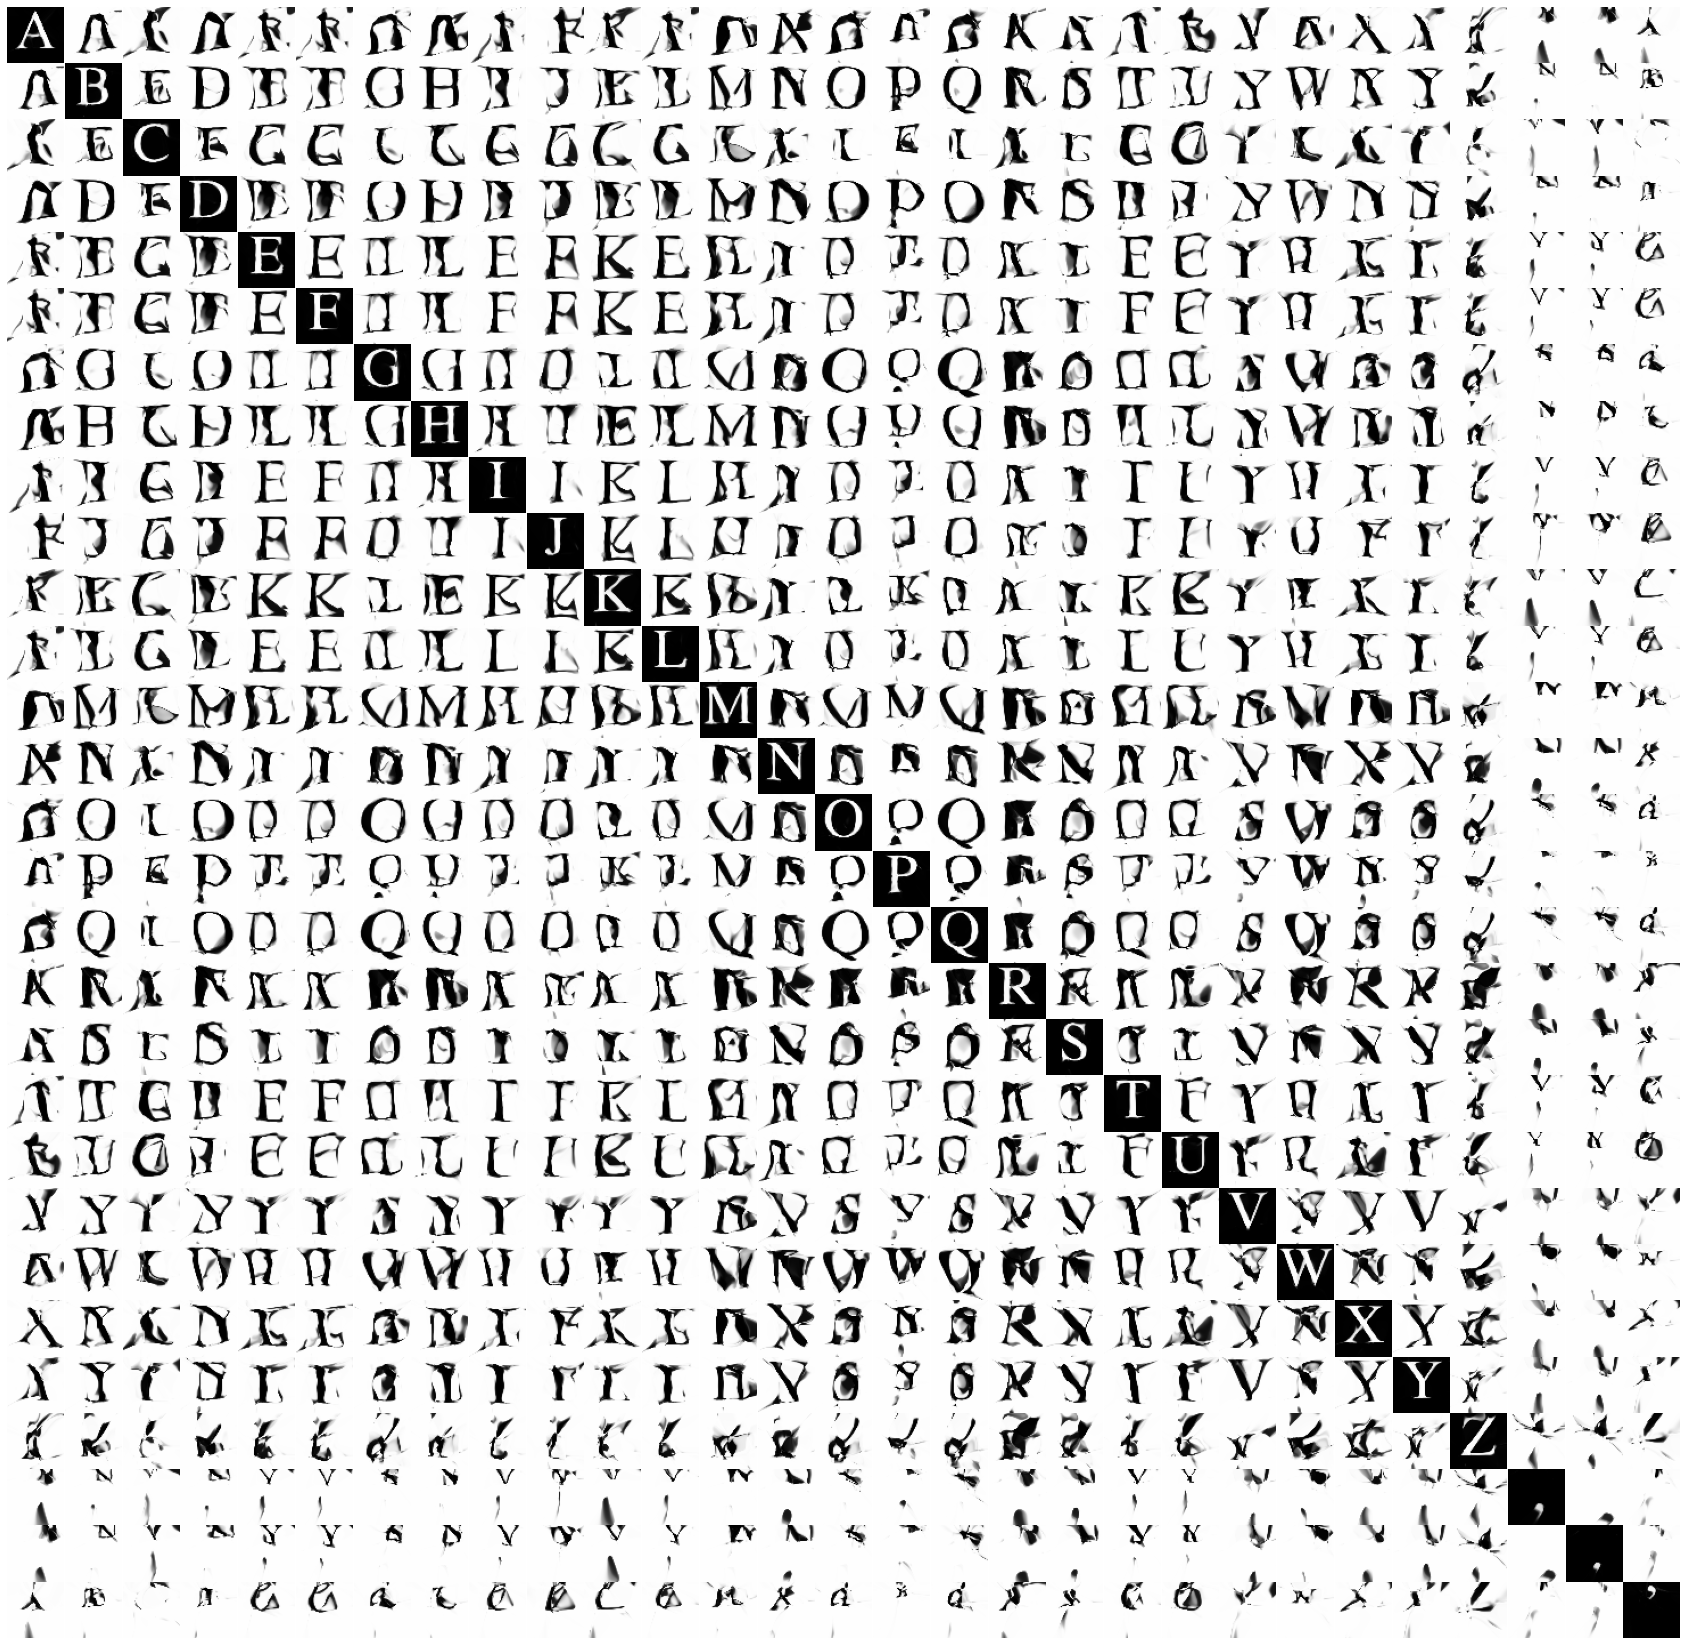

In [204]:
# draw entire grid of letter interpolations

plt.figure(figsize=(30, 30))
for i in range(n_chars):
    for j in range(n_chars):
        vector = np.zeros(n_chars)
        vector[i] += 1
        vector[j] += 1
        drawn_img = draw_image_conditional(model, custom_vector=vector, height=50)
        if (i == j): # invert optimal letters for readability
            drawn_img = np.abs(drawn_img - 1)
        plt.subplot(n_chars, n_chars, i * (n_chars) + j + 1)
        plt.imshow(drawn_img)
        plt.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)

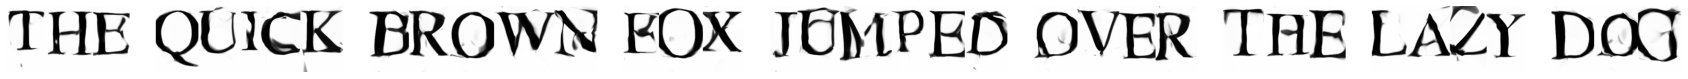

In [205]:
# draw a custom string

input = "THE QUICK BROWN FOX JUMPED OVER THE LAZY DOG"
noise = 0.04
space_width = 80
invert = False

output_list = []
# letters, width_list variables defined earlier (input cell)
for char in input:
    if char == ' ':
        output_list.append(np.ones([200, space_width, 3]))
        continue
    elif char not in letters + list(",.'"):
        continue
    if char == ',': letter_index = letters.index('comma')
    elif char == '.': letter_index = letters.index('period')
    elif char == "'": letter_index = letters.index('quoteright')
    else: letter_index = letters.index(char)

    vector = np.random.randn(n_chars) * noise
    vector[letter_index] += 1
    drawn_img = draw_image_conditional(model, i, custom_vector=vector)
    low = int(np.floor((200 - width_list[letter_index])/2))
    if low < 0:
        low = 0
    output_list.append(drawn_img[:, low:low + width_list[letter_index], :])

output_img = np.concatenate(output_list, axis=1)
if invert:
    output_img = np.abs(output_img - 1)
plt.figure(figsize=(30, 5))
plt.axis('off')
plt.imshow(output_img)